In [1]:
%matplotlib inline

import numpy as np
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, Polygon

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Creating the Map Projection

Maps have been such a mainstay of our lives for so long now that it's hard to imagine just how complex it is to create one. Keep in mind though, the earth is a 3-dimensional spherical object, and until we reach a point where some type of Star Wars-style 3-dimensional holographic map is available, and easily portable, we will be stuck with the problem of "projecting" the globe onto a 2-dimensional surface. What this means is that every map you've ever looked at was an estimation of the real world. In other words, every map you've ever used was flawed in some way, and the decision to use a particular "projection" was always met with a careful analysis of the tradeoffs associated with each one. With that in mind, it's easy to understand why the simple task of displaying a map becomes a cost/benefit analysis of the different projection mechanisms---as much art, as science---in many cases.

### What is a Projection?

You've now heard the term "projection" at least 3 different times in the previous introduction, so you may be asking yourself "what is a projection?" Well, before I answer that question, let's run through a quick thought experiment to understand the problem of map projection a bit more intuitively. 

Imagine taking an orange and drawing a map of the world on the its surface. Then, take the peel of that orange and try to flatten it out so that you have a perfectly flat map of the world. The problem that you're going to run into is that the peel cannot be flattened without ripping and leaving gaps between different areas of the map. Now, to solve the problem of ripping, we could instead do the same trick as before, but with a balloon instead of an orange peel. The problem then becomes, in the areas where there were rips before, now those areas have become stretched and distorted. In other words, the areas furthest from the center of the ballon have become substantially stretched, while those towards the center have remained relatively unchanged. A [map projection][1] then, is a mathematical formula that transforms points in a 3-dimensional space into coordinates on a 2-dimensional surface.

It's now a bit easier to see that the problem of "projecting" the world onto a 2-dimensional surface is really a question of choosing how best to distort the map given a specific purpose for its use. As an example, the inventor of the mercator projection (below), the most popular version of the world map in use today, created a map that substantially exagerated the size of the northern continents, such as Europe and North America, making them seem far bigger than those in the southern half of the world. This made it relatively easy for sailors to create perfectly straight routes along latitude and longitude lines. The cost, of course, was the exagerated land mass of the northern continents. 

I still haven't answered the question of what a projection is. To sum up, a map projection is a mathematical transformation of points in 3-dimensional space to a flat 2-dimensional surface.

So, you see, the simple act of displaying a map is really nowhere near as simple as you might think, it's really all a question of tradeoffs.





For anyone interested in learning more about map projections
The Environmental Systems Research Institute (ESRI), an international supplier of Geographic Information System (GIS) software, has released a fantastic book entitled ["Understanding Map Projections"][1]. If you're interested in 

[1]: http://downloads2.esri.com/support/documentation/ao_/710Understanding_Map_Projections.pdf

/Users/croach/developer/mastering_matplotlib/venv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


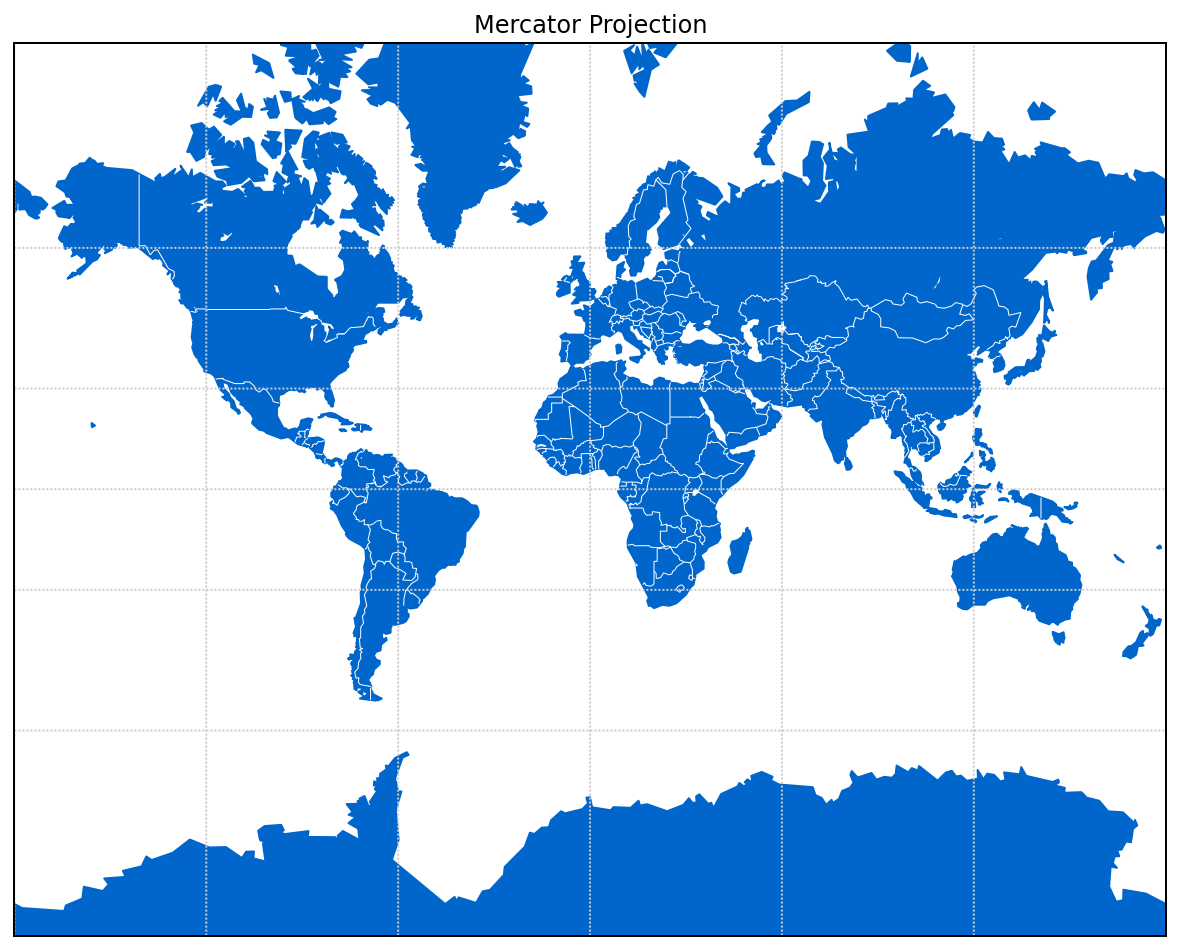

In [2]:
plt.figure(figsize=(16,8))

# Create a Basemap instance that uses the mercator projection
m = Basemap(projection='merc',
            urcrnrlat=80, llcrnrlat=-80,      # Top and Bottom parallels
            llcrnrlon=-180, urcrnrlon=180)    # Left and Right meridians

# Draw the coastlines and fill the continents all with the same blue.
# The color of inland lakes defaults to the background color of the 
# axis, but we'll set the lake_color here to make sure that it is white.
m.drawcoastlines(color='#0066CC')
m.fillcontinents(color='#0066CC', lake_color='white')

# Draw the boundaries of each country in white
m.drawcountries(color='white')

# Draw lines of latitude (parallels) and longitude (meridians)
m.drawparallels(range(-90,91,30), color='#CCCCCC')
m.drawmeridians(range(-180,181,60), color='#CCCCCC')

# Draws the bounding box around the map and sets the background 
# color (fill_color) for the entire map. 
m.drawmapboundary(fill_color='white')

# Give the map a title
plt.title("Mercator Projection");

## Load the Unemployment Data

I've included the mildly preprocessed unemployment data in this repository, so you won't have to get that yourself, but just in case you're interested in understanding every last piece of the work that was done to create this choropleth, here's a description of how to get the data:

> You can get the data from the [Bureau of Labor Statistics][1]. Select either the text or Excel format---either will need to processed a bit before it's of any use to us. I chose the XLS version since it's a little bit easier to format. If you decide to go that route, and you don't have Excel on your machine, I would suggest installing [xlsx2csv][2] and using it to convert the spreadsheet to a CSV format. After that, you'll have to remove some cruft at the top of the file and add a header to it before it will work. Also, there's an extra empty column in the spreadsheet that you'll need to remove as well. Finally, there's a bit of attribution information at the bottom of the spreadsheet/csv file that needs to be removed as well.

Now that you have the data in a format that will be easy to work with, you can read it in and create the [color map][3] that we'll be using for our unemployment map.

[1]: http://www.bls.gov/lau/#cntyaa
[2]: https://github.com/dilshod/xlsx2csv
[3]: http://matplotlib.org/users/colormaps.html

In [3]:
import csv 

def load_unemployment_rates(year):
    """Returns a dict mapping FIPS codes to unemployment rates.
    
    Arguments:
    year -- The year for which unemployment rates will be loaded
    """
    unemployment = {}
    filename = './data/unemployment%s.csv' % year
    with open(filename, 'rU') as fin:
        for row in csv.DictReader(fin):
            fips = row['state_fips_code'] + row['county_fips_code']
            # If any unemployment rates are missing, just set them to 0
            try:
                unemployment[fips] = float(row['unemployment_rate'])
            except ValueError:
                unemployment[fips] = 0
    return unemployment


unemployment = load_unemployment_rates(2009)

## Create a Color Function

To create our choropleth, we need a way to map an unemployment rate to a color. In this section, we'll create a function that will take care of that mapping for us.

The mapper function is very simple---just 3 lines in total. First, it normalizes the given unemployment rate by dividing the difference between the rate and the minimum rate in the set and dividing by the total difference between the min and max values. This will make sure that all of our unemployment rates will be between 0 and 1 which is exactly the range of values that a matplotlib color map expects. Next, we'll call an instance of a matplotlib color map with the normalized value. This will return a tuple of red, blue, green, and alpha values that we will then pass to matplotlib's `rgb2hex` before returning the hex value for the color to the caller. All of this takes palce inside of the internal function `mapper` below.

Finally, we wrap the `mapper` function in a factory function called `get_color_mapper` that takes a list of unemployment rates and an optional color map instance and returns a new instance of our `mapper` function. The reason for this is to make it easy to try out different color maps with our choropleth to find the one that looks best with our data.

In [4]:
from matplotlib.colors import rgb2hex

def get_color_mapper(unemployment_rates, cm=None, reverse=False):
    """Returns a function that maps an unemployment rate to a color.
    
    Arguments:
    unemployment_rates -- A list of unemployment rates
    
    Keyword Arguments:
    reverse -- If True, reverse the color mapping
    cm -- A color map instance
    """
    # The default color map is hot if none was passed in
    cmap = cm if cm is not None else plt.cm.hot
    
    # Get the min and max values of the unemployment rates
    umin = min(unemployment_rates)
    umax = max(unemployment_rates)

    def mapper(unemployment_rate):
        """Returns a color hex value for an unemployment rate.
        """
        # Normalize the unemployment rate by converting it 
        # into a value between 0 and 1.
        norm_unemployment_rate = (unemployment_rate - umin)/(umax - umin)
        # The hot color map runs from hot (low index values) to cold, 
        # so we'll need to invert our normalized value to make sure 
        # that larger numbers are given hotter colors.
        
        # Some of the color maps' intesity runs from high to low. With 
        # these maps, a low number would return an intense color and a 
        # high number would get a less intense color which is the 
        # opposite of what you would want. In these cases, the user can
        # set the 'reverse' flag to True to essentially flip the scale.
        if reverse:
            color = cmap(1. - norm_unemployment_rate)
        else:           
            color = cmap(norm_unemployment_rate)
        # Calling the colormap instance with a value between 0 and 1 
        # will return an rgba tuple. We don't need the alpha value,
        # so we chop it off before returning the tuple.
        return rgb2hex(color)

    return mapper

## Drawing the Choropleth

In this section we'll create a function that will draw the choropleth for a given set of unemployment rates. This function will take an instance of the `Basemap` class, a dict of unemployment rates, and a function for mapping unemployment rates to colors. Our function will only be dawing the 48 contiguous states, so we'll also need to create a list of the FIPS codes for just those states that we can use in our drawing function.

The drawing function itself is relatively simple since it assumes that the Basemap object is completely setup at the time it's passed in. Completely setup means that the shapefile for the counties has already been properly loaded into the `Basemap` object. The main functionality of our drawing function will be to loop through every county in the given `Basemap` object and add a patch to the map object containing a `Polygon` instance that will visually represent that county. To make the map a choropleth, we will first look up the unemployment rate for the county, get its cooresponding color value, and then fill the polygon with that color. This will give our map that familiar patchwork look of a choropleth.

In [5]:
# List of the FIPS codes for the 48 contiguous states 
# source: http://www.bls.gov/cew/cewedr10.htm)
contiguous_states_fips = [
    '01',   # Alabama 
    '04',   # Arizona 
    '05',   # Arkansas    
    '06',   # California  
    '08',   # Colorado    
    '09',   # Connecticut 
    '10',   # Delaware    
    '11',   # District of Columbia    
    '12',   # Florida 
    '13',   # Georgia 
    '16',   # Idaho   
    '17',   # Illinois    
    '18',   # Indiana 
    '19',   # Iowa    
    '20',   # Kansas  
    '21',   # Kentucky    
    '22',   # Louisiana   
    '23',   # Maine   
    '24',   # Maryland    
    '25',   # Massachusetts   
    '26',   # Michigan    
    '27',   # Minnesota   
    '28',   # Mississippi 
    '29',   # Missouri    
    '30',   # Montana 
    '31',   # Nebraska    
    '32',   # Nevada  
    '33',   # New Hampshire   
    '34',   # New Jersey  
    '35',   # New Mexico  
    '36',   # New York    
    '37',   # North Carolina  
    '38',   # North Dakota    
    '39',   # Ohio    
    '40',   # Oklahoma    
    '41',   # Oregon  
    '42',   # Pennsylvania    
    '44',   # Rhode Island    
    '45',   # South Carolina  
    '46',   # South Dakota    
    '47',   # Tennessee   
    '48',   # Texas   
    '49',   # Utah    
    '50',   # Vermont 
    '51',   # Virginia    
    '53',   # Washington  
    '54',   # West Virginia   
    '55',   # Wisconsin   
    '56',   # Wyoming 
]

def draw_choropleth(m, unemployment_rates, color):
    """Draws a choropleth.
    
    Arguments:
    m -- The map projection
    unemployment_rates -- A dict mapping FIPS codes to unemployment rates.
    color -- A function that takes an unemployment rate and returns 
             a hex value representing a color.
    """
    ax = plt.gca()
    for info, shape in zip(m.counties_info, m.counties):
        # We're only showing unemployment rates for the 48 contiguous states, 
        # so skip anything that doesn't show up in the list.
        if info['STATEFP'] not in contiguous_states_fips:
            continue
        try:
            fips = info['STATEFP'] + info['COUNTYFP']
            unemployment_rate = unemployment_rates[fips]
        except KeyError:
            continue
        ax.add_patch(Polygon(np.array(shape), facecolor=color(unemployment_rate), edgecolor='#221e1f', linewidth=0.5))
        

    # Calling drawmapboundary will ensure that the x- and y-axis 
    # limits are set correctly for the map and draws either simple 
    # border (or no border as in our example below) in place of a 
    # typical x- and y-axis with tick marks.
    m.drawmapboundary(color='none');

## Create the Map Object

In [6]:
# Lambert Conformal map of lower 48 states.
m = Basemap(
    # These four attributes define the bounding box, 
    # i.e., the area of the world that we want to show 
    # in our map.
    llcrnrlon=-119,
    llcrnrlat=22,
    urcrnrlon=-64,
    urcrnrlat=49,
    # We've chosen the Lambert Conformal Conic projection. 
    projection='lcc',
    # These three params define the 1st and 2nd standard 
    # parallel and the central meridian used by the projection.
    lat_1=33,          
    lat_2=45,
    lon_0=-95
   )

## Load the Counties Shapefile

[counties shapefile][1]

[1]: https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html

In [7]:
# Set drawbounds to False to make sure the map isn't drawn in this step
m.readshapefile('./shapefiles/cb_2014_us_county_500k_2d/cb_2014_us_county_500k', 'counties', drawbounds=False);

## The Great Recession

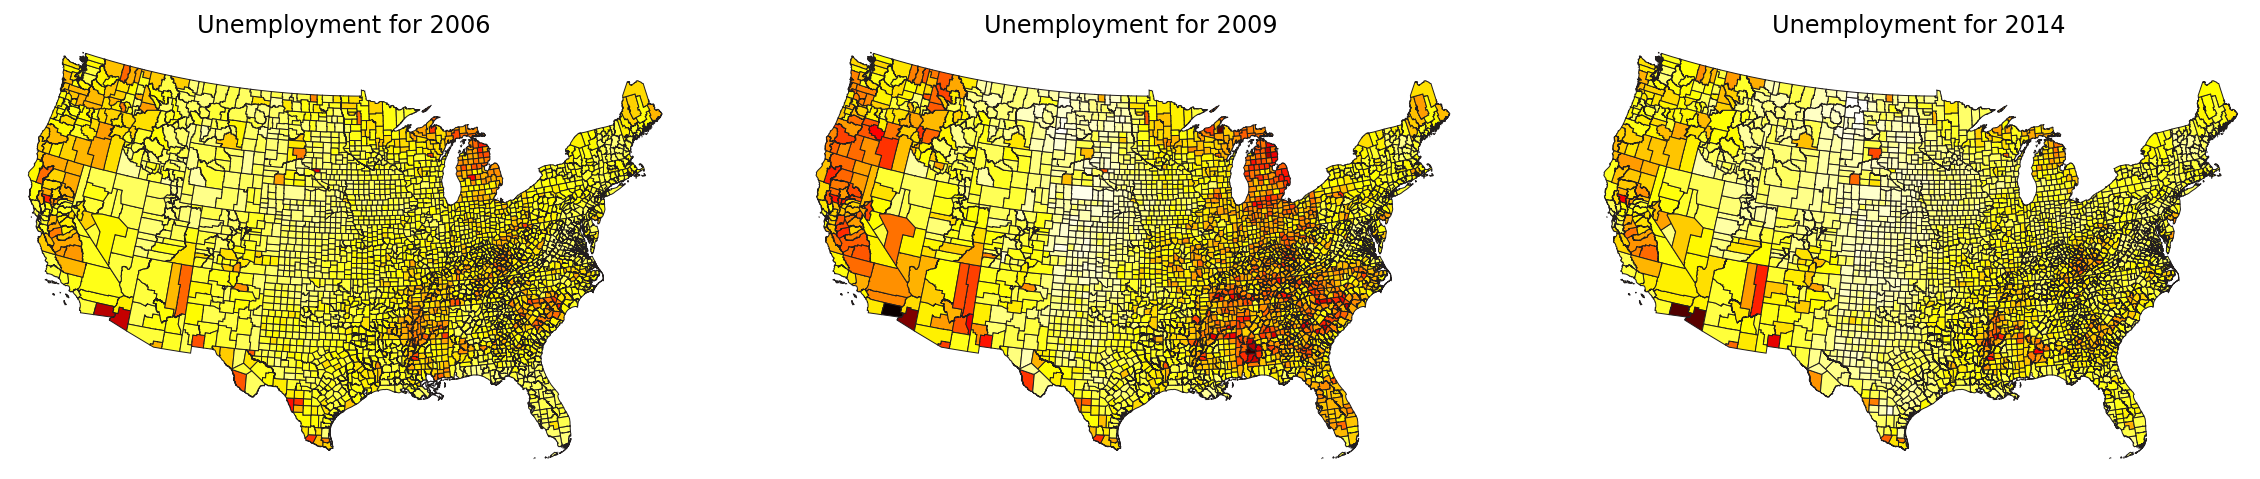

In [8]:
# The Great Recession began in 2007 and hit its peak in 2009. 
# We'll look at the unemployment rate, before it began, at its
# peak, and finally the most recent year that we have data for.
years = ['2006', '2009', '2014']

plt.figure(figsize=(20, 10))
for i, year in enumerate(years):

    # Get the data from the file
    unemployment = load_unemployment_rates(year)
    color = get_color_mapper(unemployment.values(), reverse=True)

    # Create a new subplot and add a title
    plt.subplot(1, len(years), i+1)
    plt.title('Unemployment for %s' % year)
    
    # Draw the map
    draw_choropleth(m, unemployment, color)

## The Peak of the Recession

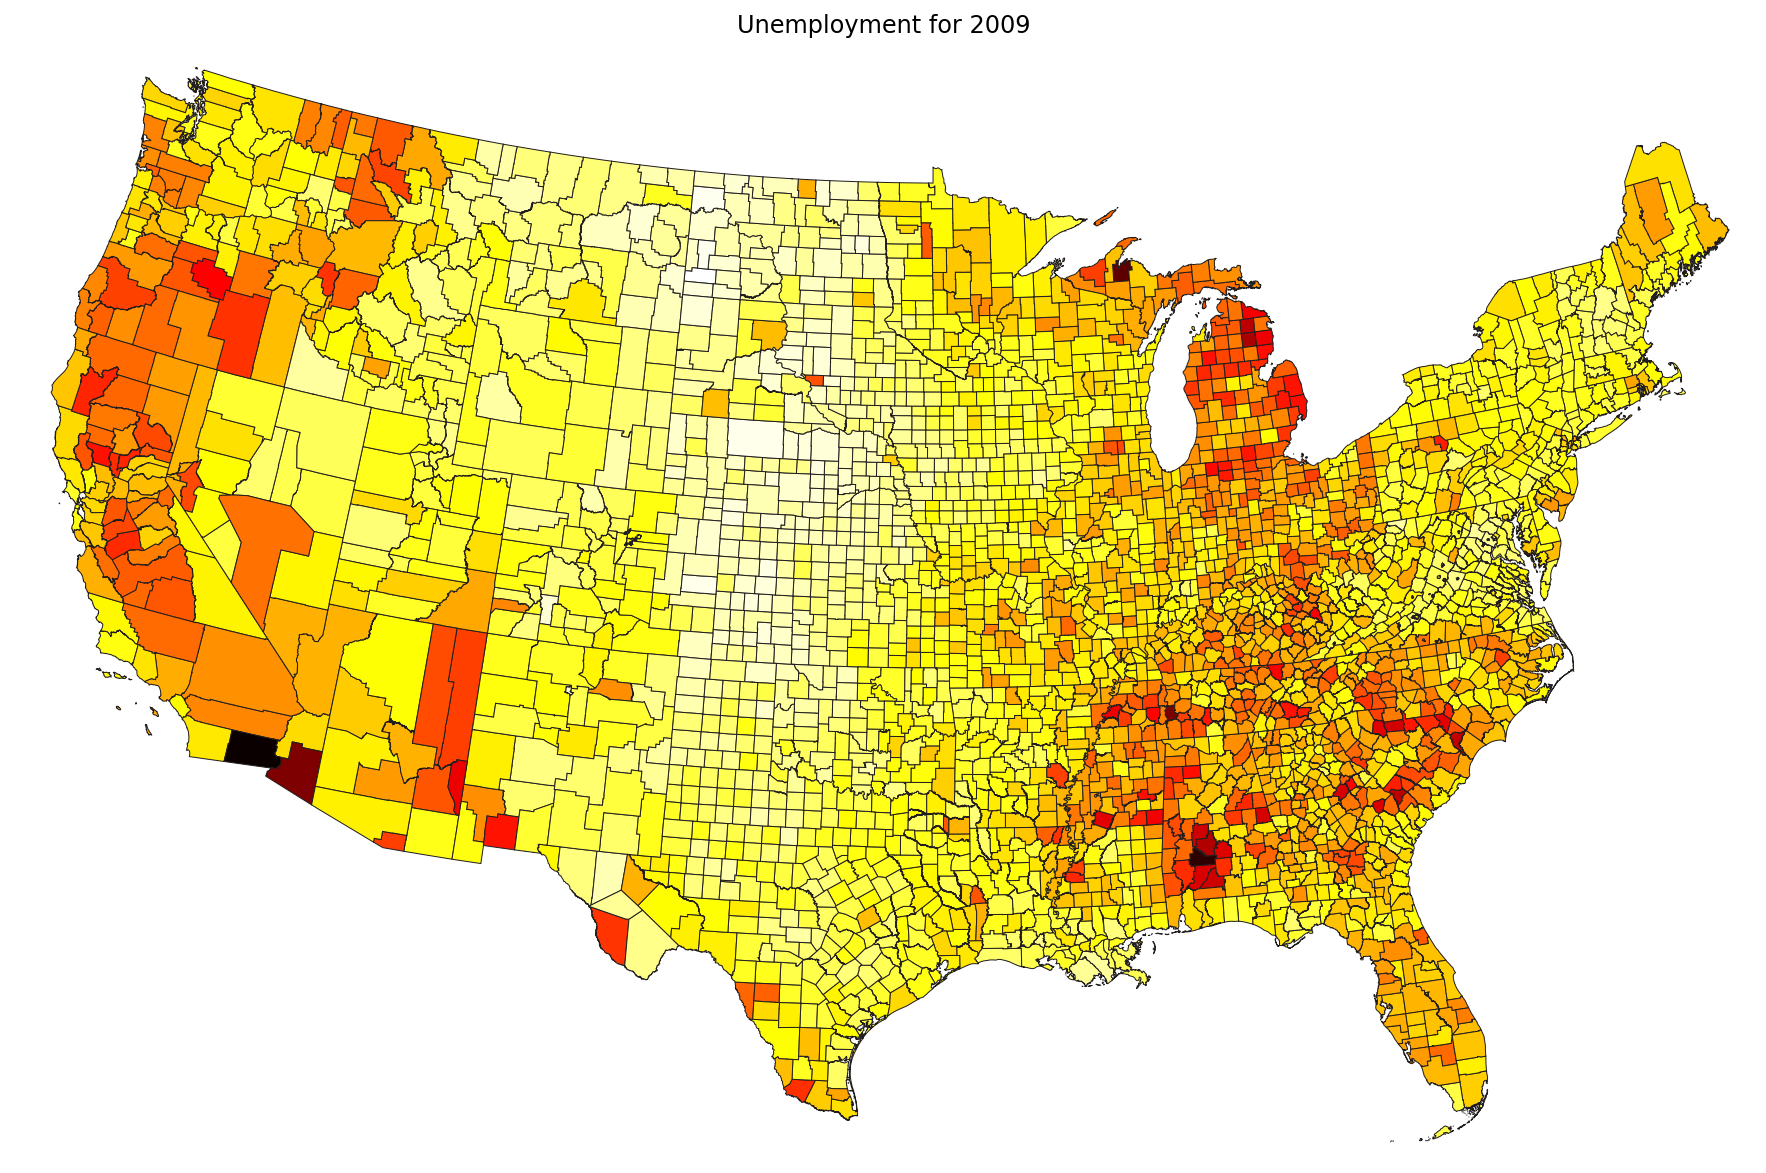

In [9]:
plt.figure(figsize=(20,10))
plt.title("Unemployment for 2009")
unemployment = load_unemployment_rates(2009)
color = get_color_mapper(unemployment.values(), reverse=True)
draw_choropleth(m, unemployment, color)